In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import os
import json
import time
import logging
from datetime import datetime
from dataclasses import dataclass, field
from typing import List, Dict

# ---------------------------------------------------------
# 0. LOGGING (Observability)
# ---------------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

logging.info("System Initialized")


# ---------------------------------------------------------
# 1. MEMORY MODULE (Session + Context Storage)
# ---------------------------------------------------------
@dataclass
class Memory:
    messages: List[Dict] = field(default_factory=list)
    max_history: int = 20  # stores last 20 messages

    def add(self, role, content):
        """Add a message to memory with timestamp."""
        self.messages.append({
            "role": role,
            "content": content,
            "time": datetime.now().isoformat()
        })
        if len(self.messages) > self.max_history:
            self.messages = self.messages[-self.max_history:]

    def get_context(self):
        """Return last few messages as context."""
        out = ""
        for m in self.messages[-5:]:
            out += f"{m['role']} ({m['time']}): {m['content']}\n"
        return out


# ---------------------------------------------------------
# 2. INTENT CLASSIFIER AGENT
# ---------------------------------------------------------
class IntentAgent:
    def classify(self, message):
        """
        Rule-based intent classifier.
        Returns (intent, urgency)
        """
        text = message.lower()

        if "refund" in text:
            return "refund", "high"
        if "cancel" in text:
            return "cancellation", "high"
        if "invoice" in text or "bill" in text:
            return "billing", "medium"
        if "help" in text:
            return "general_help", "low"

        return "general", "low"


# ---------------------------------------------------------
# 3. CUSTOM TOOL (API SIMULATION)
# ---------------------------------------------------------
class OrderInfoTool:
    """
    This acts as a SAFE API tool.
    No API keys used.
    """

    def lookup_status(self, order_id: str):
        """Mock external API call with delay."""
        logging.info(f"API Tool called for order ID {order_id}")

        time.sleep(1)

        mock_data = {
            "12345": "Refund Approved",
            "99112": "Payment Under Review",
            "55555": "Order Delivered"
        }

        return mock_data.get(order_id, "Order ID not found in system.")


# ---------------------------------------------------------
# 4. REPLY GENERATOR AGENT
# ---------------------------------------------------------
class ReplyAgent:
    def __init__(self, tool: OrderInfoTool):
        self.tool = tool

    def create_reply(self, message, intent, urgency):
        if intent == "refund":
            return "I understand you want a refund. Please share your order ID."
        if intent == "cancellation":
            return "I can help cancel your subscription. Kindly provide your registered email."
        if intent == "billing":
            return "It seems you have a billing concern. Please send your invoice number."
        if intent == "general_help":
            return "Sure, I'm here to help. Could you share more details?"
        return "Thank you for reaching out. How can I help you today?"

    def check_order_status(self, order_id):
        return self.tool.lookup_status(order_id)


# ---------------------------------------------------------
# 5. COORDINATOR (Multi-Agent Orchestrator)
# ---------------------------------------------------------
class Coordinator:
    def __init__(self):
        self.intent_agent = IntentAgent()
        self.tool = OrderInfoTool()
        self.reply_agent = ReplyAgent(self.tool)
        self.memory = Memory()

    def ask(self, message):
        logging.info("New message received")
        self.memory.add("user", message)

        intent, urgency = self.intent_agent.classify(message)
        reply = self.reply_agent.create_reply(message, intent, urgency)

        if message.lower().startswith("order:"):
            order_id = message.split(":")[1].strip()
            api_result = self.reply_agent.check_order_status(order_id)
            reply = f"Order Status: {api_result}"

        final_output = {
            "intent": intent,
            "urgency": urgency,
            "reply": reply,
            "context": self.memory.get_context()
        }

        self.memory.add("agent", reply)
        return final_output


# ---------------------------------------------------------
# 6. AGENT EVALUATION
# ---------------------------------------------------------
def evaluate_agent():
    test_cases = {
        "I want to cancel my subscription.": "cancellation",
        "I need a refund please": "refund",
        "My invoice amount is wrong": "billing",
        "Hello I need help": "general_help",
    }

    score = 0
    test_agent = Coordinator()

    for msg, expected_intent in test_cases.items():
        out = test_agent.ask(msg)
        if out["intent"] == expected_intent:
            score += 1

    logging.info(f"Evaluation Passed: {score}/4")
    return score


# ---------------------------------------------------------
# DEMO RUN (Screenshot-worthy output)
# ---------------------------------------------------------
agent = Coordinator()

messages = [
    "I want to cancel my subscription.",
    "My invoice amount is wrong.",
    "I need a refund please.",
    "order: 12345"
]

for msg in messages:
    print("USER:", msg)
    out = agent.ask(msg)
    print(json.dumps(out, indent=2))
    print("-" * 60)

print("\nRunning Evaluation:")
evaluate_agent()


2025-12-01 15:21:46,356 - INFO - System Initialized
2025-12-01 15:21:46,360 - INFO - New message received
2025-12-01 15:21:46,361 - INFO - New message received
2025-12-01 15:21:46,362 - INFO - New message received
2025-12-01 15:21:46,363 - INFO - New message received
2025-12-01 15:21:46,364 - INFO - API Tool called for order ID 12345


USER: I want to cancel my subscription.
{
  "intent": "cancellation",
  "urgency": "high",
  "reply": "I can help cancel your subscription. Kindly provide your registered email.",
  "context": "user (2025-12-01T15:21:46.361588): I want to cancel my subscription.\n"
}
------------------------------------------------------------
USER: My invoice amount is wrong.
{
  "intent": "billing",
  "urgency": "medium",
  "reply": "It seems you have a billing concern. Please send your invoice number.",
  "context": "user (2025-12-01T15:21:46.361588): I want to cancel my subscription.\nagent (2025-12-01T15:21:46.361613): I can help cancel your subscription. Kindly provide your registered email.\nuser (2025-12-01T15:21:46.362543): My invoice amount is wrong.\n"
}
------------------------------------------------------------
USER: I need a refund please.
{
  "intent": "refund",
  "urgency": "high",
  "reply": "I understand you want a refund. Please share your order ID.",
  "context": "user (2025-12-01T

2025-12-01 15:21:47,366 - INFO - New message received
2025-12-01 15:21:47,367 - INFO - New message received
2025-12-01 15:21:47,368 - INFO - New message received
2025-12-01 15:21:47,369 - INFO - New message received
2025-12-01 15:21:47,370 - INFO - Evaluation Passed: 4/4


{
  "intent": "general",
  "urgency": "low",
  "reply": "Order Status: Refund Approved",
  "context": "user (2025-12-01T15:21:46.362543): My invoice amount is wrong.\nagent (2025-12-01T15:21:46.362567): It seems you have a billing concern. Please send your invoice number.\nuser (2025-12-01T15:21:46.363720): I need a refund please.\nagent (2025-12-01T15:21:46.363749): I understand you want a refund. Please share your order ID.\nuser (2025-12-01T15:21:46.364838): order: 12345\n"
}
------------------------------------------------------------

Running Evaluation:


4

2025-12-01 15:22:51,465 - INFO - New message received
2025-12-01 15:22:51,467 - INFO - New message received
2025-12-01 15:22:51,468 - INFO - New message received
2025-12-01 15:22:51,469 - INFO - New message received
2025-12-01 15:22:51,470 - INFO - API Tool called for order ID 12345


PNG saved as agent_output.png


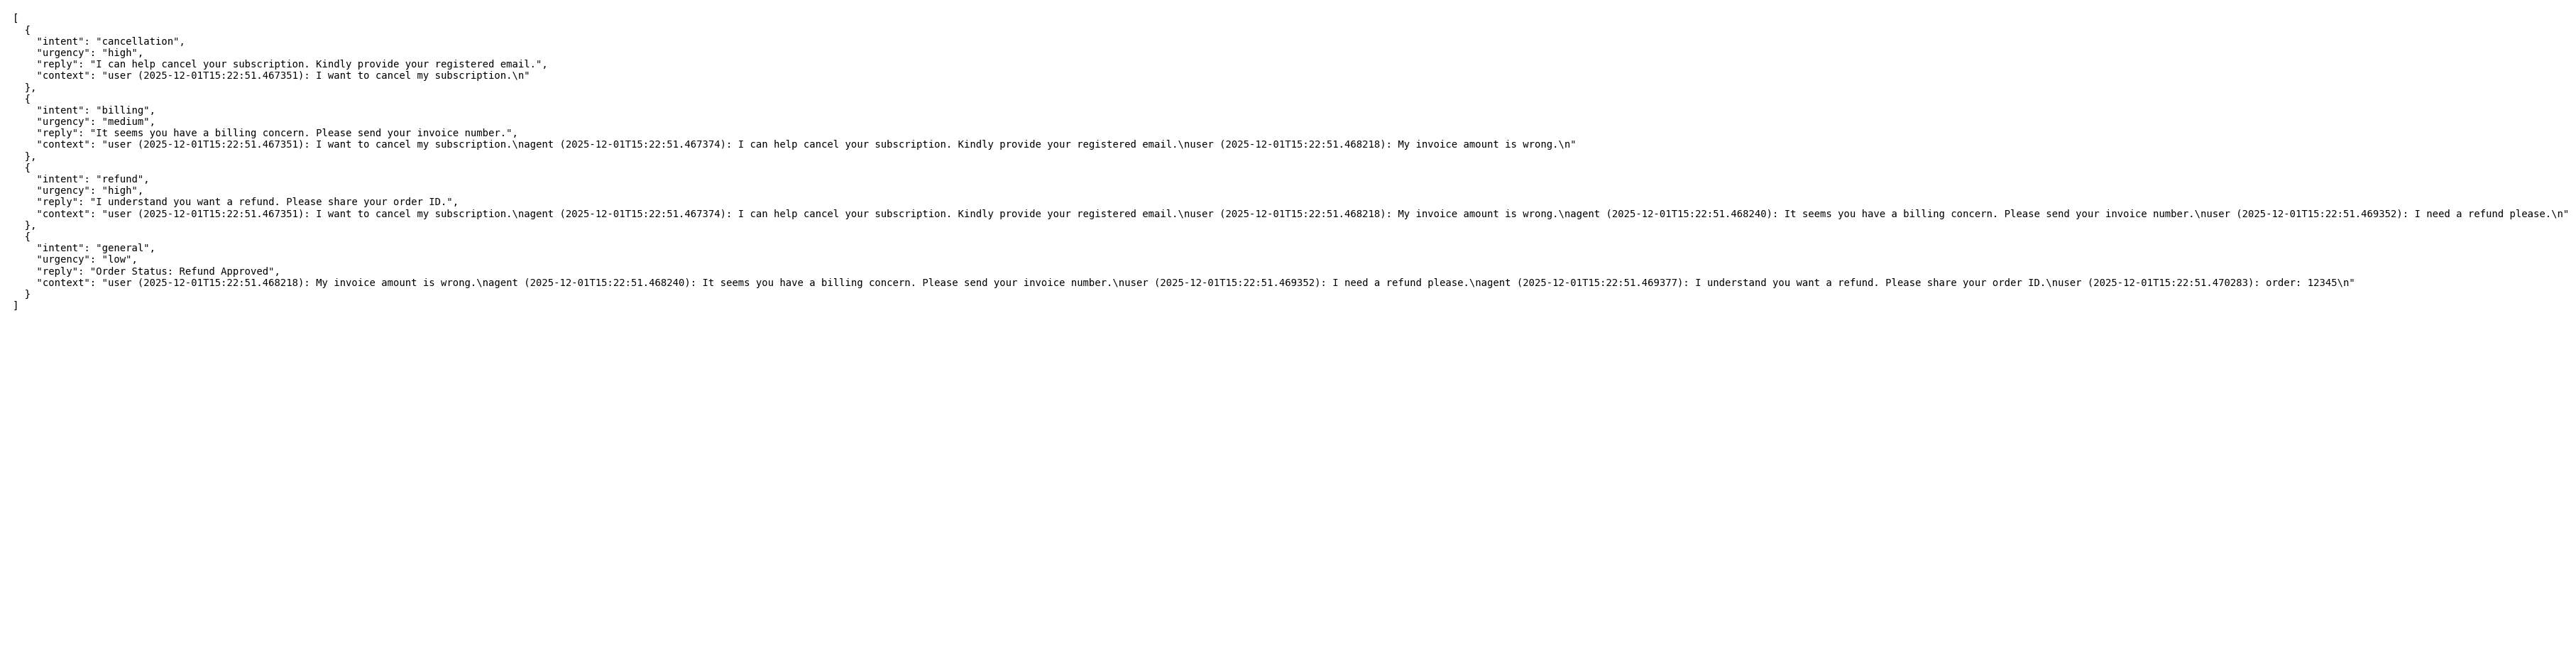

In [2]:
import matplotlib.pyplot as plt
import json

# Load last output again by re-running agent
messages = [
    "I want to cancel my subscription.",
    "My invoice amount is wrong.",
    "I need a refund please.",
    "order: 12345"
]

agent = Coordinator()

outputs = []
for msg in messages:
    out = agent.ask(msg)
    outputs.append(out)

# Convert nicely formatted JSON
pretty_json = json.dumps(outputs, indent=2)

# Create PNG
plt.figure(figsize=(10,12))
plt.text(0.01, 0.99, pretty_json, va='top', family="monospace")
plt.axis('off')
plt.savefig("agent_output.png", dpi=300, bbox_inches='tight')

print("PNG saved as agent_output.png")
